In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
df = pd.read_csv('/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv')

In [5]:
df

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


Lets start from some exploratory data analysis

In [6]:
total_images = df['ImageId'].nunique()
print(f'Total number of unique images: {total_images}')

Total number of unique images: 192556


There are more raws in the dataset as every ship detection location is in seperate raw and the same image can be in different raws for different ship coordiation masks.

In [7]:
# Number of images with ships
images_with_ships = df.dropna(subset=['EncodedPixels'])['ImageId'].nunique()
print(f'Number of images with ships: {images_with_ships}')

# Number of images without ships
images_without_ships = total_images - images_with_ships
print(f'Number of images without ships: {images_without_ships}')


Number of images with ships: 42556
Number of images without ships: 150000


In [8]:
# Number of ships
num_ships = df['EncodedPixels'].count()
print(f'Total number of ships across all images: {num_ships}')

Total number of ships across all images: 81723


Transforming a RLE code string into a list of pixels of a (768, 768) mask

In [9]:
def rle_to_pixels(rle_code):
    
    rle_code = [int(i) for i in rle_code.split()]
    pixels = [(pixel_position % 768, pixel_position // 768) 
                 for start, length in list(zip(rle_code[0:-1:2], rle_code[1::2])) 
                 for pixel_position in range(start, start + length)]
    return pixels

# drop rows with NaN EncodedPixels
ships = df.dropna(subset=['EncodedPixels'])

# add a new column "NumPixels" which will have the count of pixels for each ship
ships['NumPixels'] = ships['EncodedPixels'].apply(lambda x: len(rle_to_pixels(x)))

# calculate the average size of ships
avg_ship_size = ships['NumPixels'].mean()
print(f'Average ship size: {avg_ship_size} pixels')

# calculate the distribution of ship sizes
ship_size_dist = ships['NumPixels'].value_counts().sort_index()
print(f'Ship size distribution: \n{ship_size_dist}')


Average ship size: 1567.4028486472596 pixels
Ship size distribution: 
2        13
4        15
5         5
6         9
7        25
         ..
24214     1
24216     4
24599     2
25245     2
25904     2
Name: NumPixels, Length: 5429, dtype: int64


/tmp/ipykernel_32/3234004489.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ships['NumPixels'] = ships['EncodedPixels'].apply(lambda x: len(rle_to_pixels(x)))


Plot histogram for ship sizes

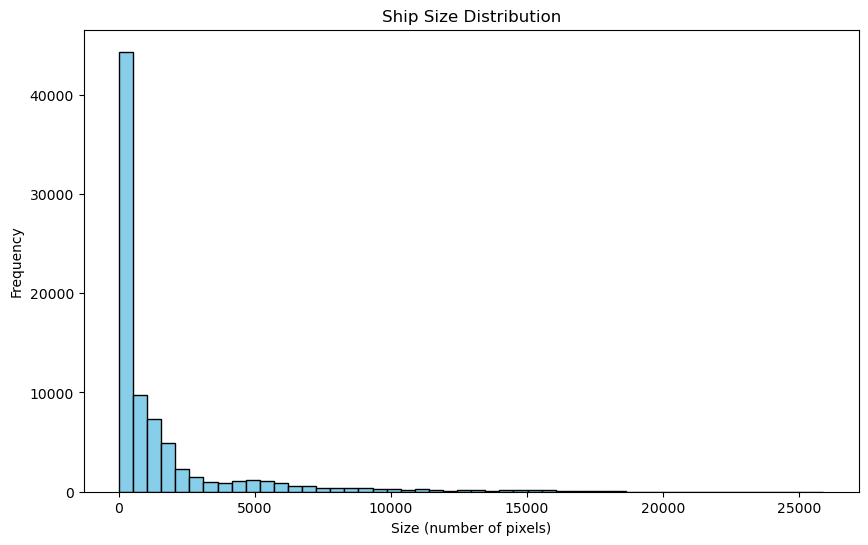

In [11]:
plt.figure(figsize=(10,6))
plt.hist(ships['NumPixels'], bins=50, color='skyblue', edgecolor='black')
plt.title('Ship Size Distribution')
plt.xlabel('Size (number of pixels)')
plt.ylabel('Frequency')
plt.show()

In [14]:
def rle_decode(mask_rle, shape=(768, 768)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


def show_img_with_mask(img_id):

    img_path = f'/kaggle/input/airbus-ship-detection/train_v2/{img_id}'
    img = cv2.imread(img_path)

    img_masks = df.loc[df['ImageId'] == img_id, 'EncodedPixels'].tolist()

    # Create empty mask
    all_masks = np.zeros((768, 768))

    # If ship is present
    if img_masks[0] != img_masks[0]:
        # No ship in this image, just show the image
        plt.imshow(img)
        plt.show()
    else:
        # Ships are present, plot mask on image
        for mask in img_masks:
            all_masks += rle_decode(mask)
        
        fig, axarr = plt.subplots(1, 2, figsize=(15, 40))
        axarr[0].axis('off')
        axarr[1].axis('off')
        axarr[0].imshow(img)
        axarr[0].title.set_text('Image')
        axarr[1].imshow(img)
        axarr[1].imshow(all_masks, alpha=0.4, cmap='Reds')
        axarr[1].title.set_text('Image with mask')

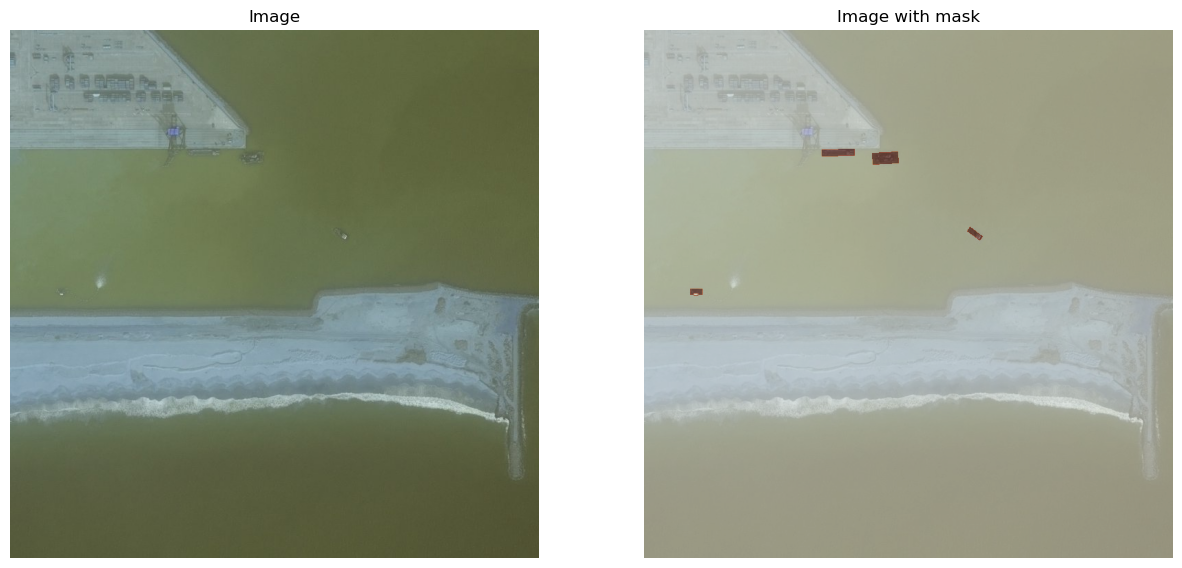

In [15]:
show_img_with_mask('000194a2d.jpg')

I created a visualization of the original image and the converted ship mask.

Frequency of Image Use: Determine how many times an image appears in the dataset. This could tell you about the distribution of ship occurrence in the images.

Image frequency: 
e6fd0c12e.jpg    15
2053a78bd.jpg    15
d3c47b3d3.jpg    15
4de149bd9.jpg    15
c8e722430.jpg    15
                 ..
591ab2331.jpg     1
591af2fb2.jpg     1
591afc23d.jpg     1
591b2dd30.jpg     1
ffffe97f3.jpg     1
Name: ImageId, Length: 192556, dtype: int64


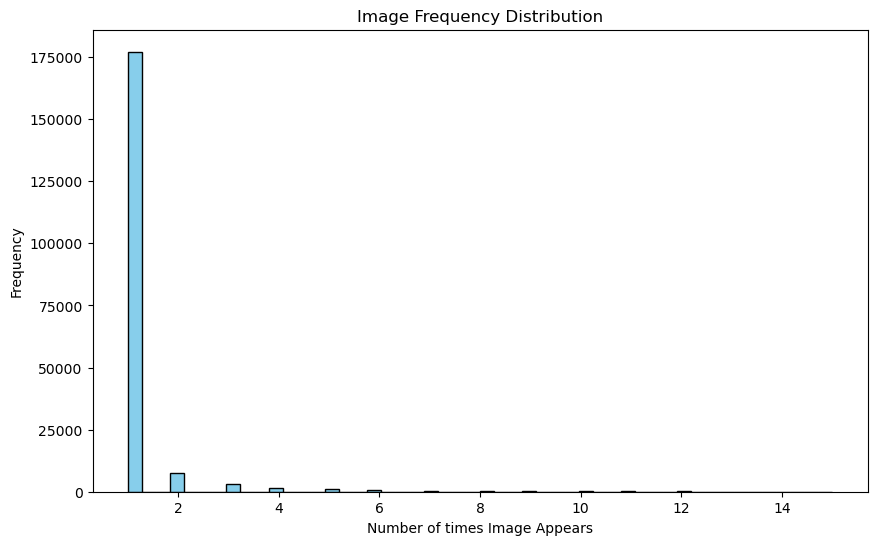

In [18]:
image_frequency = df['ImageId'].value_counts()
print(f'Image frequency: \n{image_frequency}')
plt.figure(figsize=(10,6))
plt.hist(image_frequency, bins=50, color='skyblue', edgecolor='black')
plt.title('Image Frequency Distribution')
plt.xlabel('Number of times Image Appears')
plt.ylabel('Frequency')
plt.show()


Distribution of number of ships per image: Determine how many ships appear in each image.

Ships per image distribution: 
4a4a6ccd2.jpg    15
01914baf2.jpg    15
2531669aa.jpg    15
5135c5b83.jpg    15
74150366c.jpg    15
                 ..
681a71969.jpg     1
681a64f01.jpg     1
681a34304.jpg     1
681799743.jpg     1
fffdd2377.jpg     1
Name: ImageId, Length: 42556, dtype: int64


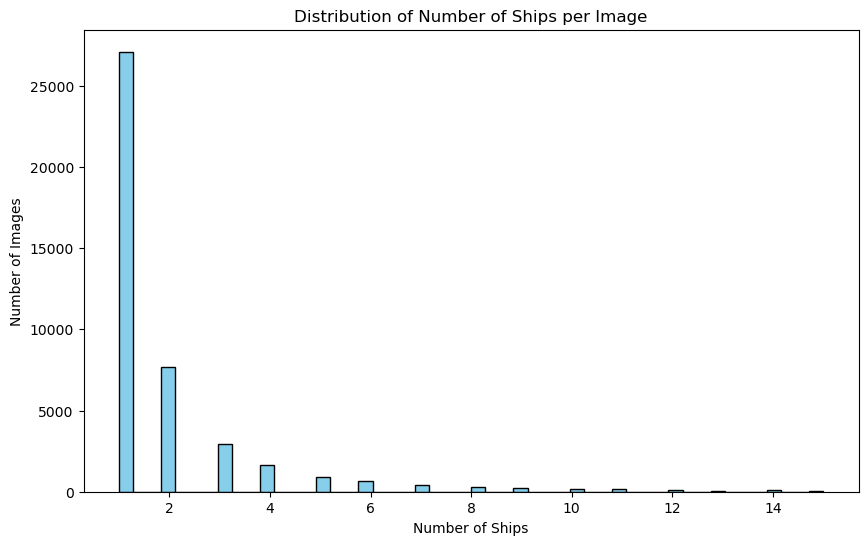

In [19]:
ships_per_image = df.dropna(subset=['EncodedPixels'])['ImageId'].value_counts()
print(f'Ships per image distribution: \n{ships_per_image}')
plt.figure(figsize=(10,6))
plt.hist(ships_per_image, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Number of Ships per Image')
plt.xlabel('Number of Ships')
plt.ylabel('Number of Images')
plt.show()


Maximum, minimum, and median ship size: Besides the average, you may want to know the smallest, largest, and median ship sizes as well.
python


In [20]:
max_ship_size = ships['NumPixels'].max()
min_ship_size = ships['NumPixels'].min()
median_ship_size = ships['NumPixels'].median()
print(f'Maximum ship size: {max_ship_size} pixels')
print(f'Minimum ship size: {min_ship_size} pixels')
print(f'Median ship size: {median_ship_size} pixels')


Maximum ship size: 25904 pixels
Minimum ship size: 2 pixels
Median ship size: 408.0 pixels


Visualize some images with the maximum and minimum number of ships: Visualizing the images with the most and fewest number of ships can provide some useful insights.

Image with maximum ships: 4a4a6ccd2.jpg
Image with minimum ships: a990766d5.jpg


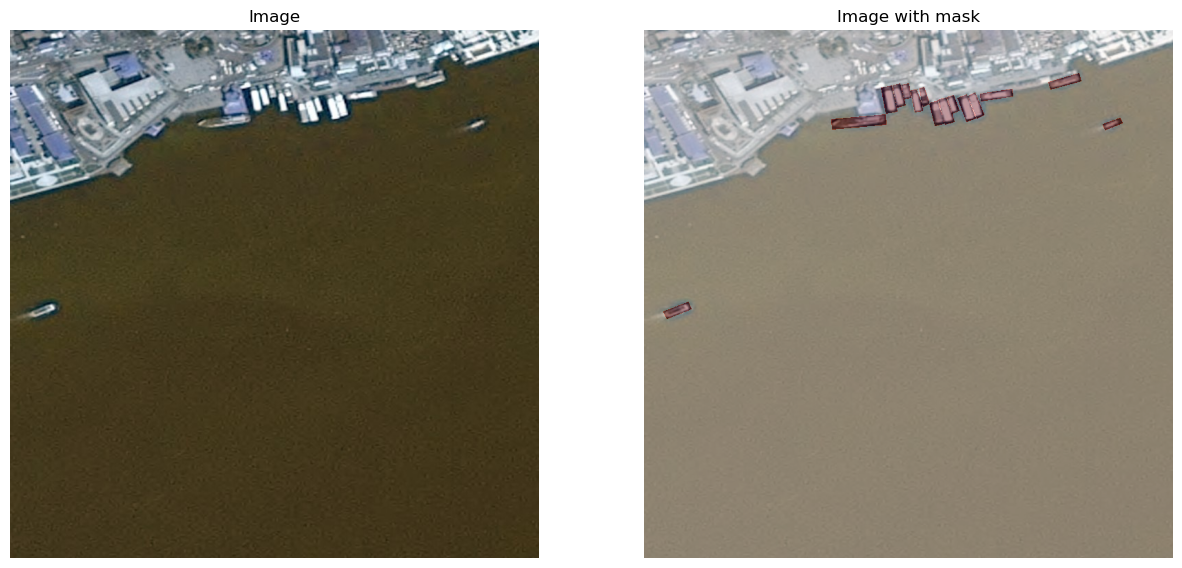

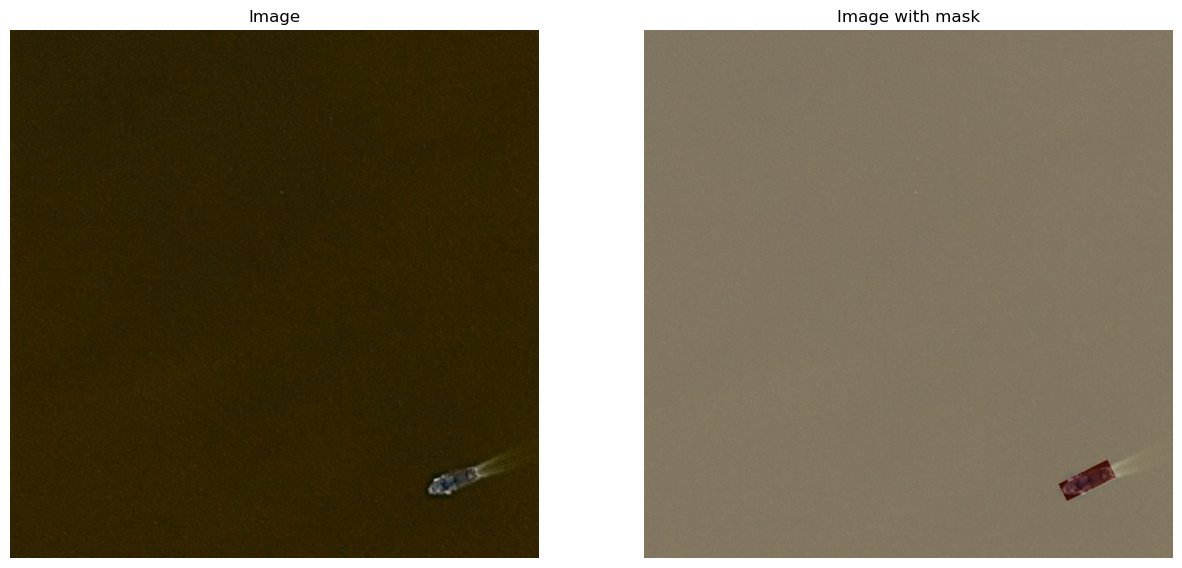

In [23]:
max_ships_image_id = ships_per_image.idxmax()
min_ships_image_id = ships_per_image.idxmin()

print(f'Image with maximum ships: {max_ships_image_id}')
show_img_with_mask(max_ships_image_id)

print(f'Image with minimum ships: {min_ships_image_id}')
show_img_with_mask(min_ships_image_id)


Quantify ship size categories: You could categorize ship sizes into small, medium, and large ships based on their pixel area and then count the number of ships in each category.

/tmp/ipykernel_32/524794652.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ships['SizeCategory'] = ships['NumPixels'].apply(categorize_size)


Ship size categories: 
large     27790
medium    26982
small     26951
Name: SizeCategory, dtype: int64


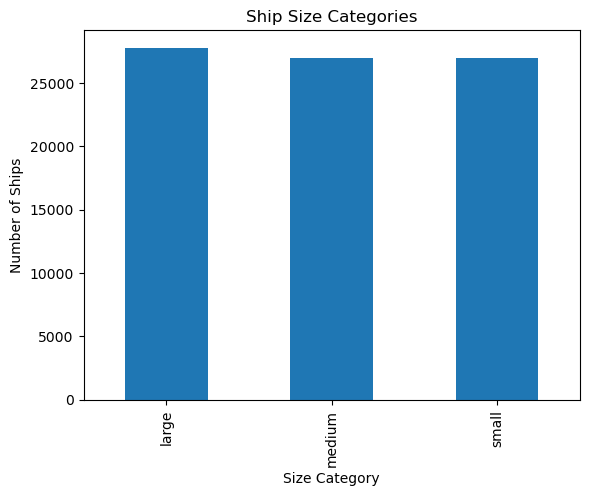

In [24]:
def categorize_size(size):
    if size < np.percentile(ships['NumPixels'], 33):
        return 'small'
    elif size < np.percentile(ships['NumPixels'], 66):
        return 'medium'
    else:
        return 'large'

ships['SizeCategory'] = ships['NumPixels'].apply(categorize_size)

ship_size_categories = ships['SizeCategory'].value_counts()
print(f'Ship size categories: \n{ship_size_categories}')
ship_size_categories.plot(kind='bar')
plt.title('Ship Size Categories')
plt.xlabel('Size Category')
plt.ylabel('Number of Ships')
plt.show()
